## Run this notebook

You can launch this notebook in VEDA JupyterHub by clicking the link below.

[Launch in VEDA JupyterHub (requires access)](https://nasa-veda.2i2c.cloud/hub/user-redirect/git-pull?repo=https://github.com/NASA-IMPACT/veda-docs&urlpath=lab/tree/veda-docs/notebooks/quickstarts/timeseries-rioxarray-stackstac.ipynb&branch=main) 

<details><summary>Learn more</summary>
    
### Inside the Hub

This notebook was written on the VEDA JupyterHub and as such is designed to be run on a jupyterhub which is associated with an AWS IAM role which has been granted permissions to the VEDA data store via its bucket policy. The instance used provided 16GB of RAM. 

See (VEDA Analytics JupyterHub Access)[https://nasa-impact.github.io/veda-docs/veda-jh-access.html] for information about how to gain access.

### Outside the Hub

The data is in a protected bucket. Please request access by emailng aimee@developmentseed.org or alexandra@developmentseed.org and providing your affiliation, interest in or expected use of the dataset and an AWS IAM role or user Amazon Resource Name (ARN). The team will help you configure the cognito client.

You should then run:

```
%run -i 'cognito_login.py'
```
    
</details>

## Approach

   1. Use `pystac_client` to open the STAC catalog and retrieve the items in the collection
   2. Use `stackstac` to create an `xarray` dataset containing all the items cropped to AOI
   3. Calculate the mean for each timestep over the AOI

In [1]:
from pystac_client import Client
import stackstac
import rioxarray  # noqa

## Declare your collection of interest

You can discover available collections the following ways:

* Programmatically: see example in the `list-collections.ipynb` notebook
* JSON API: https://staging-stac.delta-backend.com/collections
* STAC Browser: http://veda-staging-stac-browser.s3-website-us-west-2.amazonaws.com

In [2]:
STAC_API_URL = "https://staging-stac.delta-backend.com/"
collection = "no2-monthly"

## Discover items in collection for region and time of interest

Use `pystac_client` to search the STAC collection for a particular area of interest within specified datetime bounds.

In [3]:
china_bbox = [
    73.675,
    18.198,
    135.026,
    53.459,
]
datetime = "2000-01-01/2022-01-02"

In [4]:
catalog = Client.open(STAC_API_URL)

search = catalog.search(
    bbox=china_bbox, datetime=datetime, collections=[collection], limit=1000
)
items = list(search.items())
print(f"Found {len(items)} items")

Found 73 items


## Read data

Create an `xarray.DataSet` using `stackstac`

In [5]:
# This is a workaround that is planning to move up into stackstac itself
import rasterio as rio
import boto3

session = rio.session.AWSSession(boto3.Session())
gdal_env = stackstac.DEFAULT_GDAL_ENV.updated(
    always=dict(session=rio.session.AWSSession(boto3.Session()))
)

In [7]:
da = stackstac.stack(search.get_all_items(), gdal_env=gdal_env, epsg=4326)
da = da.assign_coords({"time": da.start_datetime})
da

/srv/conda/envs/notebook/lib/python3.11/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


<xarray.DataArray 'stackstac-b582a1d6fe7009055cc74eda0c6716b8' (time: 73,
                                                                band: 1,
                                                                y: 1800, x: 3600)>
dask.array<fetch_raster_window, shape=(73, 1, 1800, 3600), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/15)
    id              (time) <U37 'OMI_trno2_0.10x0.10_202201_Col3_V4.nc' ... '...
  * band            (band) <U11 'cog_default'
  * x               (x) float64 -180.0 -179.9 -179.8 ... 179.7 179.8 179.9
  * y               (y) float64 90.0 89.9 89.8 89.7 ... -89.6 -89.7 -89.8 -89.9
    start_datetime  (time) <U19 '2022-01-01T00:00:00' ... '2016-01-01T00:00:00'
    proj:bbox       object {90.0, 180.0, -90.0, -180.0}
    ...              ...
    end_datetime    (time) <U19 '2022-01-31T00:00:00' ... '2016-01-31T00:00:00'
    proj:transform  object {0.1, 0.0, 1.0, -0.1, -180.0, 90.0}
    description     <U47 'Cloud optimized default layer to display on map'
    title           <U17 'Default COG Layer'
    epsg            int64 4326
  * time            (time) <U19 '2022-01-01T00:00:00' ... '2016-01-01T00:00:00'
Attributes:
    spec:        RasterSpec(epsg=4326, bounds=(-180.0, -90.0, 180.0, 90.0), r...
    crs:         epsg:4326
    transform:   | 0.10, 0.00,-180.00|\n| 0.00,-0.10, 90.00|\n| 0.00, 0.00, 1...
    resolution:  0.1

## Clip the data to the bounding box for China

In [8]:
# Subset to Bounding Box for China
subset = da.rio.clip_box(*china_bbox)
subset

<xarray.DataArray 'stackstac-b582a1d6fe7009055cc74eda0c6716b8' (time: 73,
                                                                band: 1,
                                                                y: 354, x: 614)>
dask.array<getitem, shape=(73, 1, 354, 614), dtype=float64, chunksize=(1, 1, 354, 535), chunktype=numpy.ndarray>
Coordinates: (12/16)
    id              (time) <U37 'OMI_trno2_0.10x0.10_202201_Col3_V4.nc' ... '...
  * band            (band) <U11 'cog_default'
  * x               (x) float64 73.7 73.8 73.9 74.0 ... 134.7 134.8 134.9 135.0
  * y               (y) float64 53.5 53.4 53.3 53.2 53.1 ... 18.5 18.4 18.3 18.2
    start_datetime  (time) <U19 '2022-01-01T00:00:00' ... '2016-01-01T00:00:00'
    proj:bbox       object {90.0, 180.0, -90.0, -180.0}
    ...              ...
    proj:transform  object {0.1, 0.0, 1.0, -0.1, -180.0, 90.0}
    description     <U47 'Cloud optimized default layer to display on map'
    title           <U17 'Default COG Layer'
    epsg            int64 4326
  * time            (time) <U19 '2022-01-01T00:00:00' ... '2016-01-01T00:00:00'
    spatial_ref     int64 0
Attributes:
    spec:        RasterSpec(epsg=4326, bounds=(-180.0, -90.0, 180.0, 90.0), r...
    resolution:  0.1

## Select a band of data

There is just one band in this case, `cog_default`.

In [9]:
# select the band default
data_band = da.sel(band="cog_default")

## Aggregate the data

Calculate the mean at each time across the whole dataset. Note this is the first time that the data is actually loaded.

In [10]:
# Average over entire spatial bounding box for each month
means = data_band.mean(dim=("x", "y")).compute()

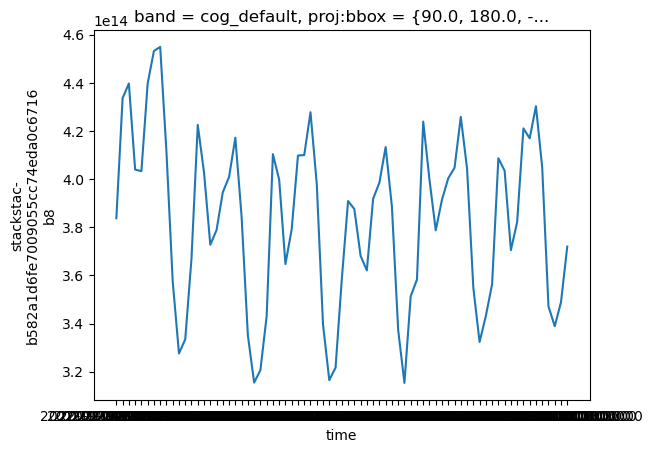

In [11]:
means.plot()